**Problem Description**

Information plays the central role to make informed decisions in this fast-paced world. The problem at hand is that there is a vast amount of information available which makes it difficult to discern the relevant information and make the best decision.

With regards to the financial market, making informed investment decisions is crucial. There is a vast amount of news and information available. To make the best informed decision, there is a need for a systematic approach to analyze stock news sentiment and its relationship to the stock price value. Understanding the correlation will allow the investor to predict the future stock value.

**Technologies Applied**

(1) Web Scraping Stock News via BeautifulSoup 

(2) Sentiment Analysis for the Stock News via NLTK

(3) Receive Current and Historic Stock Values via Yahoo Finance built-in library and Alpha Vantage API

(4) Visual Correlation Analysis between Stock News Sentiment and Stock Value

**Explanation of Technical Approaches**

Ultimately, all technical approaches chosen are simple and straightforward. Leveraging BeautifulSoup/NLTK/API's allows to analyze data provided online and understand if there is any correlation between news and outcomes. 
- I used webscraping because it allows to pull the titles/highlights of the respective news. This gives a good overview of the current company environment.
- I used NLTK since it allows to predict the sentionent of the news. I believe that this gives the end-user an understanding of the overarching feeling towards the company and the environment it operates in.
- Leveraging APIs to pull stock data allowed for automatic updates to ensure that all information is up to the latest. 

**Types of Data**

(1) Qualitative
- Text: Content of News
- Sentiment Label
- Stock Ticker Symbol

(2) Quantitative
- Stock Values
- Dates/Times

(3) Sources
- Finviz
- Alpha Vantage API
- Yahoo Finance via built-in "API library"

In [3]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup as bs
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from tabulate import tabulate
import requests

# Get ticker info
ticker = "TSLA"

# (1) WEB SCRAPE STOCK NEWS VIA BEAUTIFULSOUP
# 1A - CONNECT TO WEBSITE
url = f"https://finviz.com/quote.ashx?t={ticker}"
req = Request(url=url, headers={'user-agent': 'my-app'})
response = urlopen(req)
html = bs(response, features='html.parser')

# 1B - WEB SCRAPE FOR DATE/TIME/NEWS HEADLINE
news_table = html.find(id='news-table')
parsed_data = []
for row in news_table.find_all('tr'):
    try:
        title = row.a.text.strip()
    except AttributeError:
        continue
    date_data = row.td.text.strip()
    date_data = date_data.split(' ')

    if len(date_data) == 1:
        time = date_data[0]
    else:
        date = date_data[0]
        time = date_data[1]

    parsed_data.append((date, time, title))

# 1C - TRANSFORM PARSED DATA TO DATAFRAME & FORMAT DATE
df = pd.DataFrame(parsed_data, columns=['Date', 'Time', 'Title'])
df.loc[df['Date'] == 'Today', 'Date'] = datetime.today().strftime('%b-%d-%y')
df['Date'] = pd.to_datetime(df['Date'])

# (2) SENTIMENT ANALYSIS FOR STOCK NEWS VIA NLTK
# 2A - PERFORM SENTIMENT ANALYSIS
sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Title'])
    res[i] = sia.polarity_scores(text)

# 2B - ADD SENTIMENT LABELS
vaders = pd.DataFrame(res).T

def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.05:
        return "negative"
    elif compound >= -0.05 and compound <= 0.05:
        return "neutral"

vaders['sentiment'] = vaders['compound'].apply(lambda val: polarity_score(val))

# 2C - COMBINE OUTCOMES OF SENTIMENT ANALYSIS TO WEB SCRAPED DATA FRAME
updated_df = pd.concat([df, vaders], axis=1)

# 2D - EXTRACT SUMMARY INFO
sentiment_data = []
for date, group in updated_df.groupby('Date'):
    mean_compound = round(group['compound'].mean(), 2)
    sentiment = group['sentiment'].value_counts().idxmax()
    max_positive_headline = group.loc[group['compound'].idxmax()]['Title']
    max_negative_headline = group.loc[group['compound'].idxmin()]['Title']
    sentiment_data.append([date.strftime('%m-%d-%Y'), mean_compound, sentiment, max_positive_headline, max_negative_headline])

# (3) RECEIVE CURRENT AND HISTORIC STOCK VALUES VIA ALPHA VANTAGE API
# 3A - EXTRACT DATE RANGE (OLDEST AND NEWEST DATE) FROM STOCK NEWS
min_date = updated_df['Date'].min()
max_date = updated_df['Date'].max()

# 3B - CONNECT TO API
key = '7MG13SRCIU15YNTX'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={key}'
r = requests.get(url)
stock_data = r.json()

# 3C - CONVERT TO DATAFRAME AND FILTER FOR MIN/MAX DATES
time_series_data = stock_data["Time Series (Daily)"]
stock_df = pd.DataFrame.from_dict(time_series_data, orient="index")
stock_df.columns = ['open', 'high', 'low', 'close', 'volume']
stock_df = stock_df.apply(pd.to_numeric)
stock_df['date'] = pd.to_datetime(stock_df.index)
stock_df.set_index('date', inplace=True)
stock_df.sort_index(inplace=True)

# Ensure min_date and max_date are in the stock data
if min_date not in stock_df.index:
    min_date = stock_df.index[stock_df.index.searchsorted(min_date)]

if max_date not in stock_df.index:
    max_date = stock_df.index[stock_df.index.searchsorted(max_date) - 1]

filtered_stock_df = stock_df.loc[(stock_df.index >= min_date) & (stock_df.index <= max_date)]

# 3D - ANALYZE THE STOCK VALUES OVER PERIOD OF TIME
min_open = filtered_stock_df.loc[min_date, 'open']
max_close = filtered_stock_df.loc[max_date, 'close']
dollar_difference = max_close - min_open
percentage_difference = ((max_close - min_open) / min_open) * 100

# 3E - FORMAT FOR SUMMARY INFO IN THE TERMINAL CONSOLE
filtered_stock_df.sort_index(inplace=True)
formatted_stock_df = filtered_stock_df[['open', 'close']].copy()
formatted_stock_df.index = formatted_stock_df.index.strftime('%m-%d-%Y')
formatted_stock_df['open'] = formatted_stock_df['open'].apply(lambda x: f'${x:.2f}')
formatted_stock_df['close'] = formatted_stock_df['close'].apply(lambda x: f'${x:.2f}')

# Output to Terminal
print(f"Ticker Symbol: {ticker}")
print()

# Stock Value Overview
print("Stock Value Overview:")
print(tabulate(formatted_stock_df, headers=['Date', 'Open', 'Close'], tablefmt='pretty'))
print()
print("Opening and Closing Dollar Difference between Time Range: ${:.2f}".format(dollar_difference))
print("Opening and Closing Percentage Difference between Time Range: {:.2f}%".format(percentage_difference))
print()

# News Overview
print("Stock News Overview:")
print(tabulate(sentiment_data, headers=["Date", "Mean Compound Score", "Overall Sentiment", "Most Positive Headline", "Most Negative Headline"], tablefmt='pretty'))


C:\Users\danie\AppData\Local\Temp\ipykernel_18940\2238716956.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


  0%|          | 0/100 [00:00<?, ?it/s]

Ticker Symbol: TSLA

Stock Value Overview:
+------------+---------+---------+
|    Date    |  Open   |  Close  |
+------------+---------+---------+
| 05-15-2024 | $179.90 | $173.99 |
| 05-16-2024 | $174.10 | $174.84 |
+------------+---------+---------+

Opening and Closing Dollar Difference between Time Range: $-5.06
Opening and Closing Percentage Difference between Time Range: -2.81%

Stock News Overview:
+------------+---------------------+-------------------+----------------------------------------------------------------------------------+------------------------------------------------------------------------------------+
|    Date    | Mean Compound Score | Overall Sentiment |                              Most Positive Headline                              |                               Most Negative Headline                               |
+------------+---------------------+-------------------+----------------------------------------------------------------------------------+-

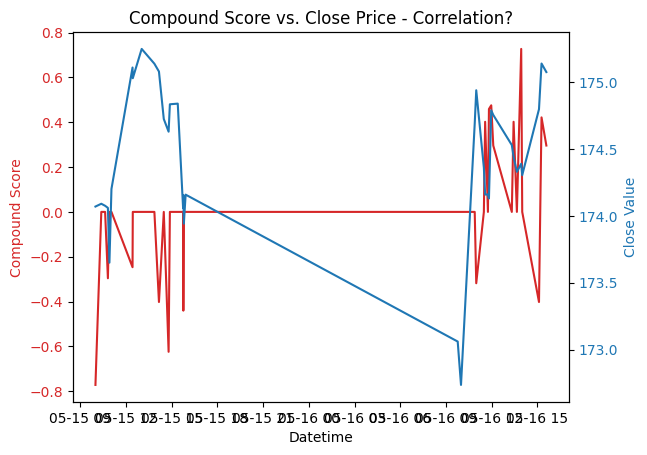

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 
from datetime import timedelta 

# (4) CORRELATION ANALYSIS BETWEEN STOCK NEWS SENTIMENT AND STOCK VALUE
## 4A - PULL INFO FROM YFINANCE
max_date += timedelta(days=1)
max_date_str = max_date.strftime('%Y-%m-%d')
min_date_str = min_date.strftime('%Y-%m-%d')

tsla = yf.Ticker(f"{ticker}")
hist = tsla.history(start=min_date_str, end=max_date_str, interval = "1m")

## 4B - FORMAT "HIST" - RESET INDEX, CONVERT TO STR, REMOVE CHARACTERS, SET NEW INDEX
hist.reset_index(inplace=True)
hist['Datetime'] = hist['Datetime'].astype(str)
hist['Datetime'] = pd.to_datetime(hist['Datetime'].str[:-6])
hist.set_index('Datetime', inplace=True)

## 4C - FORMAT "updated_df" - FORMAT TIME, MERGE DATE/TIME, SET DATETIME AS INDEX
updated_df['Time'] = updated_df['Time'].str[:-2] + ' '+ updated_df['Time'].str[-2:]

def convert_time_format(time_str):
    in_time = datetime.strptime(time_str, "%I:%M %p")
    out_time = datetime.strftime(in_time, "%H:%M:%S")
    return out_time

updated_df['Time'] = updated_df['Time'].apply(convert_time_format)

###Merge Date/Time to Match YFinance Hist
updated_df['Date'] = updated_df['Date'].astype(str)
updated_df['Datetime'] = updated_df['Date']+ ' ' + updated_df['Time']

###Set Datetime as Index & Drop Date/Time Columns
updated_df.set_index('Datetime', inplace=True)
updated_df.drop(columns=['Date', 'Time'], inplace=True)

## 4D - MERGE DATASETS
updated_df.index = pd.to_datetime(updated_df.index)
hist.index = pd.to_datetime(hist.index)
merged_df = pd.merge(updated_df, hist, left_index=True, right_index=True, how='inner')

## 4E - VISUALIZE CORRELATION

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Compound Score', color=color)
ax1.plot(merged_df.index, merged_df['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Close Value', color=color)
ax2.plot(merged_df.index, merged_df['Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)
plt.title('Compound Score vs. Close Price - Correlation?')
plt.show()